In [1]:
import os
import logging
import numpy as np
from matplotlib import pyplot as plt

from photometry import TargetSelection, utils, setup_logging

logger = logging.getLogger('SV3')
setup_logging()

plot_dir = 'plots'
run = 'south'
region = run[0].upper()
base_dir = '/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/everest/LSScats/test'
data_fn = os.path.join(base_dir, 'ELG_full.dat.fits')
randoms_fn = os.path.join(base_dir, 'ELG_0_full.ran.fits')
hp_fn = '/global/cfs/cdirs/desi/target/catalogs/dr9m/0.44.0/pixweight/main/resolve/dark/pixweight-dark.fits'
legacysim_fn = os.path.join(os.getenv('CSCRATCH'),'legacysim','dr9','SV3',run,'file0_rs0_skip0','merged','matched_input.fits')
logger.info('Filename: {}'.format(legacysim_fn))

[ 000000.00 ]: 03-10 15:02  SV3             INFO     Filename: /global/cscratch1/sd/adematti/legacysim/dr9/SV3/south/file0_rs0_skip0/merged/matched_input.fits


In [2]:
def isELG_colors(gflux=None, rflux=None, zflux=None, w1flux=None,
                 w2flux=None, gfiberflux=None, south=True, primary=None,
                 gmarg=0., grmarg=0., rzmarg=0.):
    """
    Apply ELG selection with box enlarged by ``gmarg``, ``grmarg``, ``rzmarg``.

    SV3 selection from https://github.com/desihub/desitarget/blob/7786db0931d23ed20de7ef37a6f07a52072e11ab/py/desitarget/sv3/sv3_cuts.py#L526
    """
    if primary is None:
        primary = np.ones_like(rflux, dtype='?')
    elg = primary.copy()

    # ADM work in magnitudes instead of fluxes. NOTE THIS IS ONLY OK AS
    # ADM the snr masking in ALL OF g, r AND z ENSURES positive fluxes.
    g = 22.5 - 2.5*np.log10(gflux.clip(1e-16))
    r = 22.5 - 2.5*np.log10(rflux.clip(1e-16))
    z = 22.5 - 2.5*np.log10(zflux.clip(1e-16))
    gfib = 22.5 - 2.5*np.log10(gfiberflux.clip(1e-16))

    # ADM cuts shared by the northern and southern selections.
    elg &= g > 20 - gmarg                # bright cut.
    elg &= r - z > 0.15 - rzmarg         # blue cut.
#    elg &= r - z < 1.6 + rzmarg         # red cut.

    # ADM cuts that are unique to the north or south. Identical for sv3
    # ADM but keep the north/south formalism in case we use it later.
    if south:
        elg &= gfib < 24.1 + gmarg  # faint cut.
        elg &= g - r < 0.5*(r - z) + 0.1 + grmarg  # remove stars, low-z galaxies.
    else:
        elg &= gfib < 24. + gmarg  # faint cut.
        elg &= g - r < 0.5*(r - z) + 0.1 + grmarg  # remove stars, low-z galaxies.

    # ADM separate a low-priority and a regular sample.
    elgvlo = elg.copy()

    # ADM low-priority OII flux cut.
    elgvlo &= g - r < -1.2*(r - z) + 1.6 + grmarg
    elgvlo &= g - r >= -1.2*(r - z) + 1.3 - grmarg

    # ADM high-priority OII flux cut.
    elg &= g - r < -1.2*(r - z) + 1.3 + grmarg

    return elgvlo, elg


def mask_ts(self,key_flux='EFLUX',key_fiberflux='EFIBERFLUX',region=region,gmarg=0.,grmarg=0.,rzmarg=0.,gcut=-np.inf):
    mask = isELG_colors(gflux=self['{}_G'.format(key_flux)],rflux=self['{}_R'.format(key_flux)],
                        zflux=self['{}_Z'.format(key_flux)],gfiberflux=self['{}_G'.format(key_fiberflux)],south=region=='S',
                        gmarg=gmarg,grmarg=grmarg,rzmarg=rzmarg)
    mask = mask[0] | mask[1]
    mask &= self['{}_G'.format(key_flux)] > gcut
    return mask

TargetSelection.mask_ts = mask_ts

In [3]:
# legacysim
legacysim = TargetSelection.load_objects(legacysim_fn, radecbox=None, tracer='ELG', region=None)
legacysim.set_upper_case()
legacysim['RA'] = legacysim['INPUT_RA']
legacysim['DEC'] = legacysim['INPUT_DEC']
#legacysim['MATCHED'] = legacysim['DISTANCE'] < 0.15/3600.
logger.info('Found {:d}/{:d} matches.'.format(legacysim['MATCHED'].sum(),legacysim.size))
for b in legacysim.bands:
    legacysim['INPUT_EFLUX_{}'.format(b)] = utils.mag_to_flux(legacysim['INPUT_{}'.format(b)])
legacysim['INPUT_EFIBERFLUX_G'] = utils.mag_to_flux(legacysim['INPUT_GFIBER'])
legacysim.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
legacysim['EFIBERFLUX_G'] = legacysim.estimated_flux('G',key_transmission='MW_TRANSMISSION',key_flux='FIBERFLUX')
mask_tsin = legacysim.mask_ts(key_flux='INPUT_EFLUX',key_fiberflux='INPUT_EFIBERFLUX',region=region)
#mask_tsin &= legacysim.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS')
mask_tsout = legacysim.mask_ts(key_flux='EFLUX',key_fiberflux='EFIBERFLUX',region=region) & legacysim['MATCHED']
#mask_tsout &= legacysim.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS')
logger.info('Selecting {:d} (output)/{:d} (input) injected sources.'.format(mask_tsout.sum(),mask_tsin.sum()))
legacysim_data = legacysim[mask_tsout]
legacysim_randoms = legacysim[mask_tsin]

[ 000000.55 ]: 03-10 15:02  Catalogue       INFO     Loading catalogue /global/cscratch1/sd/adematti/legacysim/dr9/SV3/south/file0_rs0_skip0/merged/matched_input.fits.
[ 000308.10 ]: 03-10 15:07  TargetSelection INFO     Selecting 1021550/1021550 targets.
[ 000420.28 ]: 03-10 15:09  SV3             INFO     Found 816268/1021550 matches.
[ 000422.14 ]: 03-10 15:09  SV3             INFO     Selecting 41112 (output)/37584 (input) injected sources.


In [4]:
spectro = True

def mask_data_zok(data, dchi2=0.9, tsnrcut=80):
    mask = data['o2c'] > dchi2
    mask &= data['ZWARN']*0 == 0
    mask &= data['ZWARN'] != 999999
    mask &= data['LOCATION_ASSIGNED'] == 1
    mask &= data['TSNR2_ELG'] > tsnrcut
    return mask

def mask_randoms_zok(randoms, tsnrcut=80):
    mask = randoms['TSNR2_ELG'] > tsnrcut
    return mask

# ELG targets, TS applied already
bricknames = np.unique(legacysim['BRICKNAME'])
logger.info('Found {:d} bricknames'.format(bricknames.size))
data = TargetSelection.load_objects(data_fn,region=region)
mask = np.in1d(data['BRICKNAME'],bricknames)
#mask[:] = True # do not cut data on the same bricks as legacysim
data.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
data['EFIBERFLUX_G'] = data.estimated_flux('G',key_transmission='MW_TRANSMISSION',key_flux='FIBERFLUX')
data.set_mag_from_flux(key_flux='EFLUX')

mask &= data.mask_ts(key_flux='EFLUX',key_fiberflux='EFIBERFLUX',region=region)
#mask &= data.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS')
if spectro: mask &= mask_data_zok(data)
data['WEIGHT'] = data.ones()
nreal = 128
nassign = nreal*data['PROB_OBS'] + 1. #assignment in actual observation counts
if spectro: data['WEIGHT'] *= (nreal+1)/nassign
logger.info('Selecting {:d}/{:d} targets.'.format(mask.sum(), mask.size))
data = data[mask]

randoms = TargetSelection.load_objects(randoms_fn,region=region)
mask = np.in1d(randoms['BRICKNAME'],bricknames)
#mask[:] = True
#mask &= randoms.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS')
if spectro: mask &= mask_randoms_zok(randoms)
randoms = randoms[mask]

def from_map(cat, fields):
    import healpy as hp
    map = Catalogue.load(hp_fn)
    theta,phi = utils.radec_to_thphi(cat['RA'],cat['DEC'])
    hppix = hp.ang2pix(map.header['HPXNSIDE'],theta,phi,nest=map.header['HPXNEST'],lonlat=False)
    for field in fields: cat[field] = map[field][hppix]

[ 000423.76 ]: 03-10 15:09  SV3             INFO     Found 1891 bricknames
[ 000423.83 ]: 03-10 15:09  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/everest/LSScats/test/ELG_full.dat.fits.
[ 000468.95 ]: 03-10 15:10  TargetSelection INFO     Selecting 232540/435386 targets.
[ 000470.81 ]: 03-10 15:10  SV3             INFO     Selecting 143699/232540 targets.
[ 000471.77 ]: 03-10 15:10  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/everest/LSScats/test/ELG_0_full.ran.fits.
[ 000474.05 ]: 03-10 15:10  TargetSelection INFO     Selecting 202347/405167 targets.


[ 000474.91 ]: 03-10 15:10  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/target/catalogs/dr9m/0.44.0/pixweight/main/resolve/dark/pixweight-dark.fits.
[ 000476.89 ]: 03-10 15:10  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000476.95 ]: 03-10 15:10  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000476.95 ]: 03-10 15:10  HealpixDensity  INFO     Found 2511 bricks with randoms.


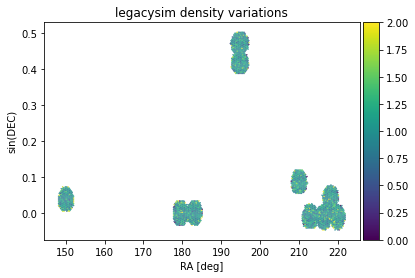

[ 000478.19 ]: 03-10 15:10  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000478.20 ]: 03-10 15:10  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000478.21 ]: 03-10 15:10  HealpixDensity  INFO     Found 1996 bricks with randoms.
[ 000478.22 ]: 03-10 15:10  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000478.23 ]: 03-10 15:10  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000478.23 ]: 03-10 15:10  HealpixDensity  INFO     Found 2511 bricks with randoms.
[ 000478.78 ]: 03-10 15:10  Properties      INFO     Calculating EBV statistics.
[ 000478.83 ]: 03-10 15:10  HealpixDensity  INFO     Fraction of randoms not included in EBV plot: 0.0188.
[ 000478.84 ]: 03-10 15:10  Properties      INFO     Calculating EBV statistics.
[ 000478.91 ]: 03-10 15:10  HealpixDensity  INFO     Fraction of randoms not included in EBV plot: 0.0190.
[ 000478.92 ]: 03-10 15:10  Properties      INFO     Calculating GALDEPTH_G statistics.
[ 00

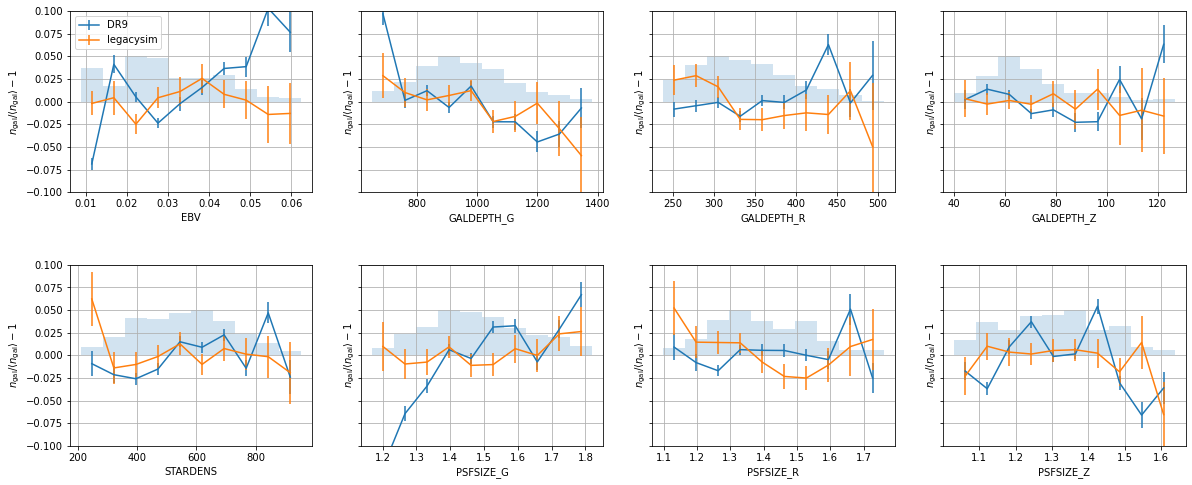

In [5]:
from photometry import Catalogue, HealpixDensity

# Density maps
map = Catalogue.load(hp_fn)
legacysim_dens = HealpixDensity(map=map)
legacysim_dens.set_randoms(randoms=legacysim_randoms)
legacysim_dens.set_properties()
legacysim_dens.set_data(data=legacysim_data)
legacysim_dens.plot_density_map(title='legacysim density variations',vmin=0,vmax=2)

props = ['EBV'] + ['GALDEPTH_{}'.format(b) for b in data.bands] + ['STARDENS'] + ['PSFSIZE_{}'.format(b) for b in data.bands]

dens = HealpixDensity(map=map)
#dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
dens.set_randoms(randoms=randoms)
dens.set_properties()
dens.set_data(data=data,key_weight='WEIGHT')

legacysim_dens = HealpixDensity(map=map)
#legacysim_dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
legacysim_dens.set_randoms(randoms=legacysim_randoms)
legacysim_dens.set_properties()
legacysim_dens.set_data(data=legacysim_data)

others = [legacysim_dens]
labels = ['DR9','legacysim']

fig,lax = plt.subplots(ncols=4,nrows=2,sharex=False,sharey=True,figsize=(20,8))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
lax = lax.flatten()
for iax,prop in enumerate(props):
    dens.plot_density_variations(ax=lax[iax],others=others,prop=prop,histos=[dens],var_kwargs={'labels':labels if iax==0 else None},leg_kwargs={},ylim=(-0.1,0.1),xedges={'quantiles':[0.01,0.99]})
filename = os.path.join(plot_dir,'density_{}.png'.format(run))
fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

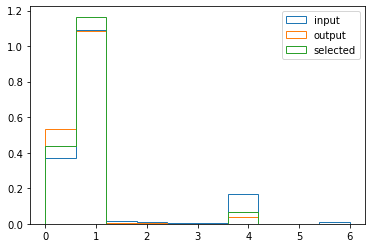

In [6]:
ax = plt.gca()
ax.hist(legacysim['INPUT_SERSIC'], histtype='step', label='input', density=True)
ax.hist(legacysim['SERSIC'], histtype='step', label='output', density=True)
ax.hist(legacysim_data['SERSIC'], histtype='step', label='selected', density=True)
#ax.hist(data['SERSIC'], histtype='step', label='in data', density=True)
ax.legend()

[ 000485.39 ]: 03-10 15:10  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/target/catalogs/dr9m/0.44.0/pixweight/main/resolve/dark/pixweight-dark.fits.
[ 000500.02 ]: 03-10 15:10  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000500.13 ]: 03-10 15:10  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000500.14 ]: 03-10 15:10  HealpixDensity  INFO     Found 2121 bricks with randoms.
[ 000500.20 ]: 03-10 15:10  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000500.27 ]: 03-10 15:10  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000500.27 ]: 03-10 15:10  HealpixDensity  INFO     Found 2478 bricks with randoms.
[ 000500.37 ]: 03-10 15:10  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000500.40 ]: 03-10 15:10  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000500.41 ]: 03-10 15:10  HealpixDensity  INFO     Found 1866 bricks with randoms.
[ 000501.07 ]: 03-10 15:10  Pro

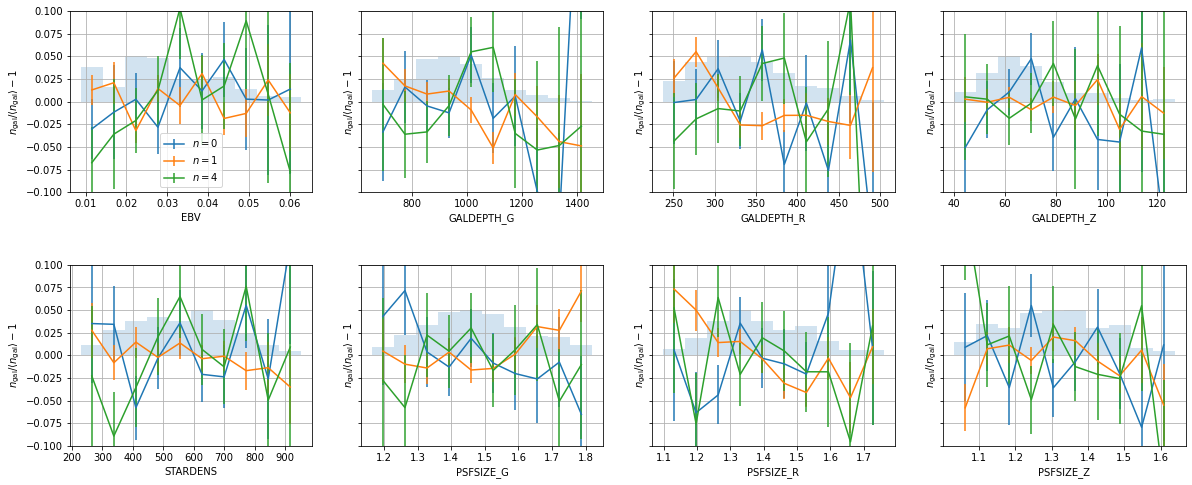

In [7]:
from photometry import Catalogue, HealpixDensity

# Density maps
map = Catalogue.load(hp_fn)

props = ['EBV'] + ['GALDEPTH_{}'.format(b) for b in data.bands] + ['STARDENS'] + ['PSFSIZE_{}'.format(b) for b in data.bands]

others = []
labels = []
for sersic in [0, 1, 4]:
    legacysim_dens = HealpixDensity(map=map)
    #legacysim_dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
    legacysim_dens.set_randoms(randoms=legacysim_randoms[legacysim_randoms['INPUT_SERSIC'] == sersic])
    legacysim_dens.set_properties()
    legacysim_dens.set_data(data=legacysim_data[legacysim_data['INPUT_SERSIC'] == sersic])
    others.append(legacysim_dens)
    labels.append('$n = {:d}$'.format(sersic))

dens, others = others[0], others[1:]

fig,lax = plt.subplots(ncols=4,nrows=2,sharex=False,sharey=True,figsize=(20,8))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
lax = lax.flatten()
for iax,prop in enumerate(props):
    dens.plot_density_variations(ax=lax[iax],others=others,prop=prop,histos=[dens],var_kwargs={'labels':labels if iax==0 else None},leg_kwargs={},ylim=(-0.1,0.1),xedges={'quantiles':[0.01,0.99]})
filename = os.path.join(plot_dir,'density_{}.png'.format(run))
fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

[ 000508.69 ]: 03-10 15:10  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000508.72 ]: 03-10 15:10  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000508.72 ]: 03-10 15:10  HealpixDensity  INFO     Found 1996 bricks with randoms.
[ 000508.74 ]: 03-10 15:10  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000508.75 ]: 03-10 15:10  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000508.75 ]: 03-10 15:10  HealpixDensity  INFO     Found 2511 bricks with randoms.
[ 000508.76 ]: 03-10 15:10  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000508.91 ]: 03-10 15:10  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000508.93 ]: 03-10 15:10  HealpixDensity  INFO     Found 2478 bricks with randoms.
[ 000510.32 ]: 03-10 15:10  Properties      INFO     Calculating EBV statistics.
[ 000510.45 ]: 03-10 15:10  HealpixDensity  INFO     Fraction of randoms not included in EBV plot: 0.0188.
[ 000510.45 ]:

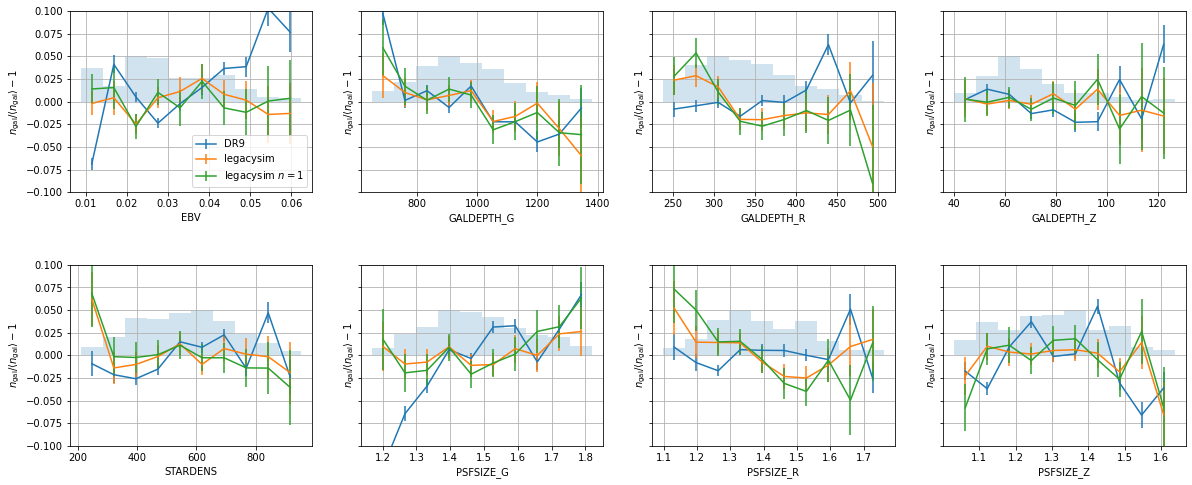

In [8]:
from photometry import Catalogue, HealpixDensity

props = ['EBV'] + ['GALDEPTH_{}'.format(b) for b in data.bands] + ['STARDENS'] + ['PSFSIZE_{}'.format(b) for b in data.bands]

dens = HealpixDensity(map=map)
#dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
dens.set_randoms(randoms=randoms)
dens.set_properties()
dens.set_data(data=data,key_weight='WEIGHT')

others = []
labels = ['DR9']

for sersic in [None, 1]:
    legacysim_dens = HealpixDensity(map=map)
    #legacysim_dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
    if sersic is not None:
        legacysim_dens.set_randoms(randoms=legacysim_randoms[legacysim_randoms['INPUT_SERSIC'] == sersic])
    else:
        legacysim_dens.set_randoms(randoms=legacysim_randoms)
    legacysim_dens.set_properties()
    if sersic is not None:
        legacysim_dens.set_data(data=legacysim_data[legacysim_data['INPUT_SERSIC'] == sersic])
    else:
        legacysim_dens.set_data(data=legacysim_data)
    others.append(legacysim_dens)
    labels.append('legacysim' if sersic is None else 'legacysim $n = {:d}$'.format(sersic))

fig,lax = plt.subplots(ncols=4,nrows=2,sharex=False,sharey=True,figsize=(20,8))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
lax = lax.flatten()
for iax,prop in enumerate(props):
    dens.plot_density_variations(ax=lax[iax],others=others,prop=prop,histos=[dens],var_kwargs={'labels':labels if iax==0 else None},leg_kwargs={},ylim=(-0.1,0.1),xedges={'quantiles':[0.01,0.99]})
filename = os.path.join(plot_dir,'density_{}.png'.format(run))
fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()